<a href="https://colab.research.google.com/github/sbeencho/ewha-git/blob/main/NN_Closed_World_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Closed World Scenario


**Objective**
* To classify the 95 monitored websites based on their trafficc patterns

**Assumption**
* All data samples belong to one of the 95 monitored websites
* No external or unmoniotred websites are present in the dataset



## Mount at Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Packages

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Data Preparation and Labeling

In [ ]:
# Set the data path
path = '/content/drive/MyDrive/2024-2/ML/data/mon_standard.pkl'

# Load data
with open(path, 'rb') as fi:
    data = pickle.load(fi)

# Parameters
USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS = 950
n_steps = 100  # Sequence Length (It can be changed if needed)

# Prepare data arrays
X1, X2, y = [], [], []

# Process data
for i in range(TOTAL_URLS):
    label = i // URL_PER_SITE if not USE_SUBLABEL else i
    for sample in data[i]:
        time_seq = []
        size_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        # Pad or truncate sequences to ensure consistent length
        if len(time_seq) > n_steps:
            time_seq = time_seq[:n_steps]
            size_seq = size_seq[:n_steps]
        else:
            time_seq += [0] * (n_steps - len(time_seq))
            size_seq += [0] * (n_steps - len(size_seq))
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)

# Convert to numpy arrays
X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)

## Normalize and Split data

**Feature combination**
  * Combine x1 and x2 to create the final input data (X).

**Label transformation**
  * Convert the labels (y) into **One-hot Encoding** to fit the classification.

**Normalization**
* Normalize the input data using **MinMaxScaler** to scale values between **0 and 1**.

**Data splitting**
* Split the data **80% training data** (X_train, y_train) and **20% validation data** (X_val, y_val).

In [ ]:
# Combine features(X1, X2) for CNN input
X = np.hstack((X1, X2))  # By combining X1 and X2, make an input data

# y consists of classes ranging from 0 to 94. Convert it to one-hot encoding
y = to_categorical(np.array(y), num_classes=95) # One-hot encode labels

# Normalize the data (feature scaling)
scaler = MinMaxScaler() # Use MinMaxScaler
X_scaled = scaler.fit_transform(X)  # Scale X between 0 and 1

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (15200, 200)
Validation data shape: (3800, 200)


## Define CNN Model

**Model architecture** </br>
A CNN is built with:
  * **3 hidden layers** with 128, 64, and 32 neurons, respectively
  * **Dropout** to prevent overfitting and improve generalization
  * **Sortmax output layer** to predict probabilities for the 95 classes

**Action funcctions** </br>
  * **ReLU** is used in hidden layers to introduce nonlinearity and speed up training.
  * **Softmax** activation is applied in the output layer to handle multi-class classification, ensuring the model outputs a probability distribution for the 95 classes.

**Optimization**
  * The model is compiled with **Adam** optimizer, which adapts learning rates during training for more efficient convergence.
  * **Categorical Crossentropy** is used as the loss function, suitable for multi-class classification problems.

**Training process**
  * The model is trained with **early stopping** to monitor validation loss and halt training if no improvement is observed for a set number of epochs.
  * The **best weights** from the training process are restored to ensure optimal performance.

In [ ]:
# Define CNN model
model = Sequential()

# Input layer + First hidden layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # 128 neurons, input size is the number of features in X_train
model.add(Dropout(0.2))  # Dropout (20%) to prevent overfitting

# Second hidden layer
model.add(Dense(64, activation='relu'))  # 64 neurons

# Third hidden layer
model.add(Dense(32, activation='relu'))  # 32개의 neurons

# Output layer (95 classes)
model.add(Dense(95, activation='softmax'))  # Predict 95 classes

# Compile the model (Adam optimizer and categorical_crossentropy loss function)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor the loss on the validation dataset
    patience=5,                   # Stop training after 5 epochs if no improvement in validation loss
    restore_best_weights=True     # Restore the best model weights upon stopping
)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                     │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 95)                  │           3,135 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,199 (153.12 KB)

 Trainable params: 39,199 (153.12 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,             # Training data and labels
    epochs=50,                    # Set the number of epochs to 50 (can be adjusted as needed)
    batch_size=32,                # Batch size of 32
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping],   # Include the EarlyStopping callback function
    verbose=2                     # Display training progress
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Epoch 1/50
475/475 - 3s - 6ms/step - accuracy: 0.2063 - loss: 3.5248 - val_accuracy: 0.4111 - val_loss: 2.4235
Epoch 2/50
475/475 - 2s - 5ms/step - accuracy: 0.4656 - loss: 2.1623 - val_accuracy: 0.5300 - val_loss: 1.8871
Epoch 3/50
475/475 - 2s - 3ms/step - accuracy: 0.5294 - loss: 1.7998 - val_accuracy: 0.5771 - val_loss: 1.6461
Epoch 4/50
475/475 - 3s - 6ms/step - accuracy: 0.5755 - loss: 1.5941 - val_accuracy: 0.6155 - val_loss: 1.4849
Epoch 5/50
475/475 - 2s - 4ms/step - accuracy: 0.6099 - loss: 1.4492 - val_accuracy: 0.6350 - val_loss: 1.3787
Epoch 6/50
475/475 - 1s - 3ms/step - accuracy: 0.6318 - loss: 1.3464 - val_accuracy: 0.6603 - val_loss: 1.3034
Epoch 7/50
475/475 - 1s - 3ms/step - accuracy: 0.6544 - loss: 1.2445 - val_accuracy: 0.6692 - val_loss: 1.2341
Epoch 8/50
475/475 - 1s - 3ms/step - accuracy: 0.6759 - loss: 1.1734 - val_accuracy: 0.6905 - val_loss: 1.1638
Epoch 9/50
475/475 - 1s - 3ms/step - accuracy: 0.6858 - loss: 1.1064 - val_accuracy: 0.6932 - val_loss: 1.1103
E

## Result Visualization

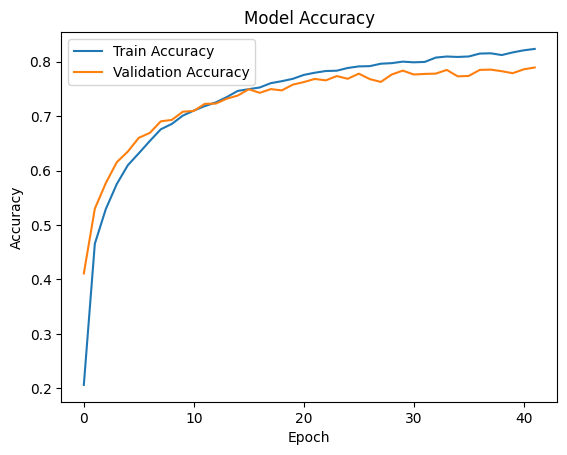

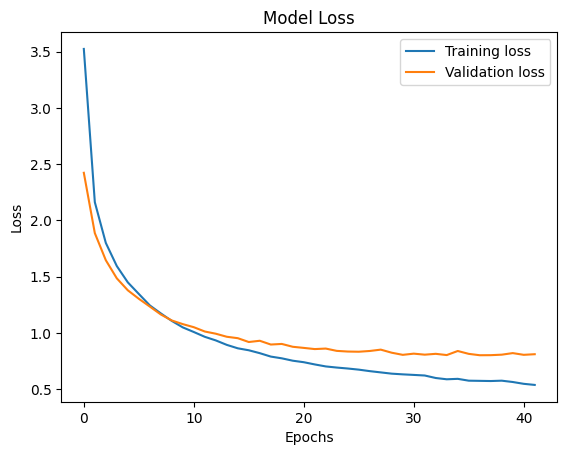

In [ ]:
import matplotlib.pyplot as plt

# Visualize training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.legend()  # Display the legend
plt.title('Model Accuracy')  # Title of the plot
plt.show()  # Display the plot

# Plot the loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')  # Title of the plot
plt.show()

##Show the model performance

Show the model performance using **Accuracy, Precision, Recall, F1-score, and Confusion Matrix**

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 78.50%
Precision: 0.7959
Recall: 0.7875
F1-Score: 0.7837


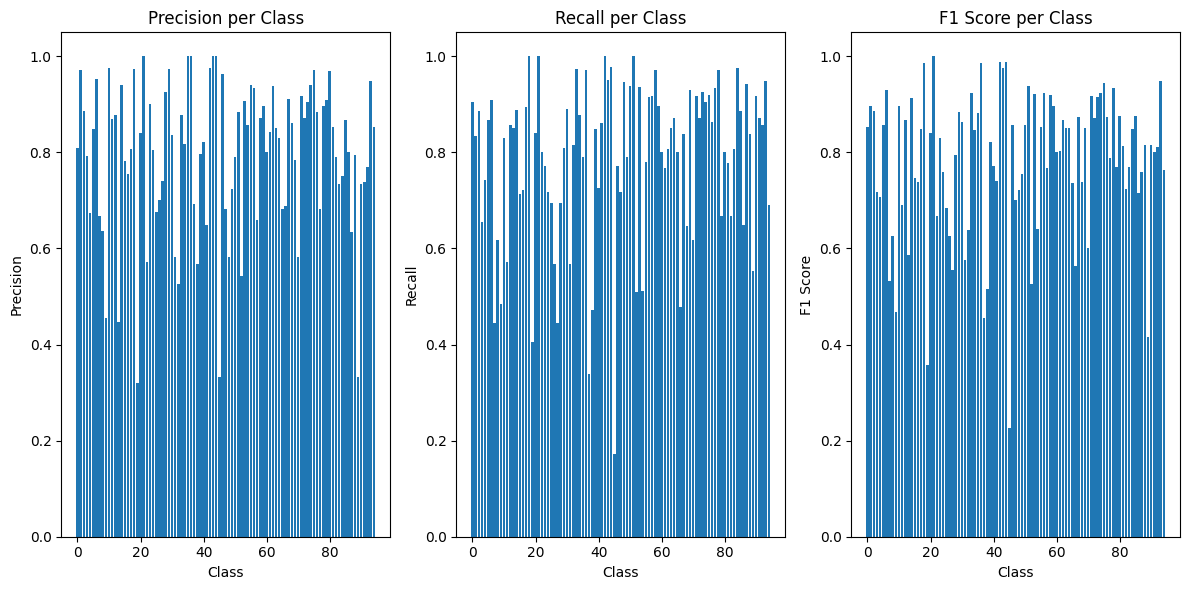

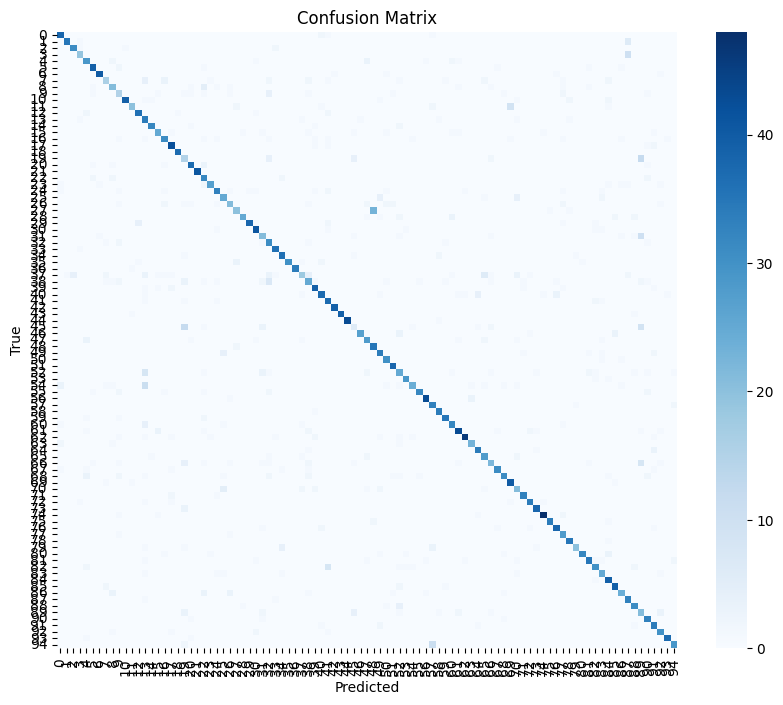

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

# Predict the labels for the validation set
y_pred = model.predict(X_val)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

precision_per_class = precision_score(y_true_classes, y_pred_classes, average=None)
recall_per_class = recall_score(y_true_classes, y_pred_classes, average=None)
f1_per_class = f1_score(y_true_classes, y_pred_classes, average=None)

# 각 클래스별로 정밀도, 재현율, F1-점수 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.bar(np.arange(95), precision_per_class)
plt.title("Precision per Class")
plt.xlabel("Class")
plt.ylabel("Precision")

plt.subplot(1, 3, 2)
plt.bar(np.arange(95), recall_per_class)
plt.title("Recall per Class")
plt.xlabel("Class")
plt.ylabel("Recall")

plt.subplot(1, 3, 3)
plt.bar(np.arange(95), f1_per_class)
plt.title("F1 Score per Class")
plt.xlabel("Class")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()


# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix (Heat map)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=np.arange(95), yticklabels=np.arange(95))
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()